In [1]:
using Pkg;
Pkg.activate("../");

using PyCall;
pygui(:tk);

  Activating project at `d:\GitHub\book-dp1`

In [2]:
include("s_approx.jl")
using LinearAlgebra, QuantEcon

function create_rs_utility_model(;
        n=180,      # size of state space
        β=0.95,     # time discount factor
        ρ=0.96,     # correlation coef in AR(1)
        σ=0.1,      # volatility
        θ=-1.0)     # risk aversion
    mc = tauchen(n, ρ, σ, 0, 10)  # n_std = 10
    x_vals, P = mc.state_values, mc.p 
    r = x_vals      # special case u(c(x)) = x
    return (; β, θ, ρ, σ, r, x_vals, P)
end

function K(v, model)
    (; β, θ, ρ, σ, r, x_vals, P) = model
    return r + (β/θ) * log.(P * (exp.(θ*v)))
end

function compute_rs_utility(model)
    (; β, θ, ρ, σ, r, x_vals, P) = model
    v_init = zeros(length(x_vals))
    v_star = successive_approx(v -> K(v, model), 
                               v_init, tolerance=1e-10)
    return v_star
end


# Plots

using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering
fontsize=16

function plot_v(; savefig=false, 
                  figname="../figures/rs_utility_1.pdf")

    fig, ax = plt.subplots(figsize=(10, 5.2))
    model = create_rs_utility_model()
    (; β, θ, ρ, σ, r, x_vals, P) = model

    a = 1/(1 - (ρ*β))
    b = (β /(1 - β)) * (θ/2) * (a*σ)^2 
    
    v_star = compute_rs_utility(model)
    v_star_a = a * x_vals .+ b
    ax.plot(x_vals, v_star, lw=2, alpha=0.7, label="approximate fixed point")
    ax.plot(x_vals, v_star_a, "k--", lw=2, alpha=0.7, label=L"v(x)=ax + b")
    ax.set_xlabel(L"x", fontsize=fontsize)

    ax.legend(frameon=false, fontsize=fontsize, loc="upper left")
    if savefig
        fig.savefig(figname)
    end
end




function plot_multiple_v(; savefig=false, 
                  figname="../figures/rs_utility_2.pdf")

    fig, ax = plt.subplots(figsize=(10, 5.2))
    σ_vals = 0.05, 0.1

    for σ in σ_vals
        model = create_rs_utility_model(σ=σ)
        (; β, θ, r, x_vals, P) = model
        v_star = compute_rs_utility(model)
        ax.plot(x_vals, v_star, lw=2, alpha=0.7, label=L"\sigma="*"$σ")
        ax.set_xlabel(L"x", fontsize=fontsize)
        ax.set_ylabel(L"v(x)", fontsize=fontsize)
    end

    ax.legend(frameon=false, fontsize=fontsize, loc="upper left")
    if savefig
        fig.savefig(figname)
    end
end


plot_multiple_v (generic function with 1 method)

Completed iteration 25 with error 0.6551733102188564.
Completed iteration 50 with error 0.16567516808198945.
Completed iteration 75 with error 0.044889308777882775.
Completed iteration 100 with error 0.012367970868957912.
Completed iteration 125 with error 0.0034238793852026106.
Completed iteration 150 with error 0.0009491803696306533.
Completed iteration 175 with error 0.00026324562215052083.
Completed iteration 200 with error 7.301768051348745e-5.
Completed iteration 225 with error 2.025401865068943e-5.
Completed iteration 250 with error 5.6182266447990514e-6.
Completed iteration 275 with error 1.5584352581754501e-6.
Completed iteration 300 with error 4.322935041045639e-7.
Completed iteration 325 with error 1.1991370030273174e-7.
Completed iteration 350 with error 3.326281472482151e-8.
Completed iteration 375 with error 9.226766906067496e-9.
Completed iteration 400 with error 2.559410461344669e-9.
Completed iteration 425 with error 7.099600907167769e-10.
Completed iteration 450 with 

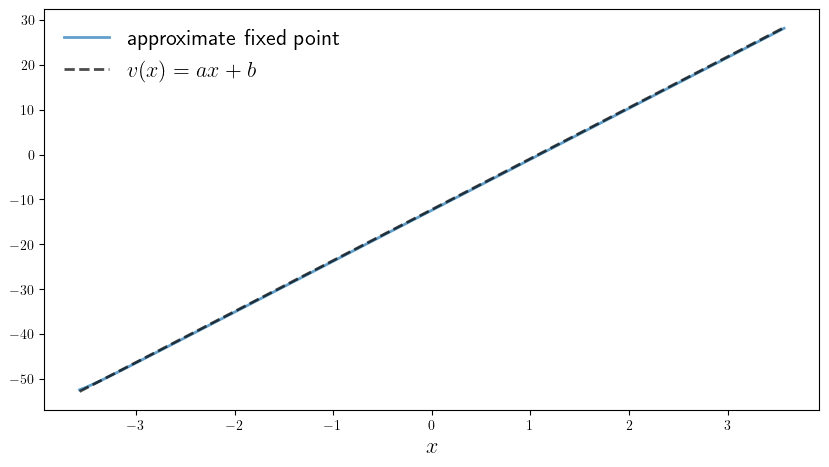

In [3]:
plot_v(savefig=true)

Completed iteration 25 with error 0.2636239967879277.
Completed iteration 50 with error 0.05190477488617873.
Completed iteration 75 with error 0.01235054779784761.
Completed iteration 100 with error 0.003222014685647423.
Completed iteration 125 with error 0.0008733772549120999.
Completed iteration 150 with error 0.00024022882517016342.
Completed iteration 175 with error 6.643334072009566e-5.
Completed iteration 200 with error 1.840755902904334e-5.
Completed iteration 225 with error 5.104029845881541e-6.
Completed iteration 250 with error 1.4156012113630823e-6.
Completed iteration 275 with error 3.926526765951621e-7.
Completed iteration 300 with error 1.0891572443938458e-7.
Completed iteration 325 with error 3.021188277330111e-8.
Completed iteration 350 with error 8.38044300621732e-9.
Completed iteration 375 with error 2.3246471414495318e-9.
Completed iteration 400 with error 6.448388489843637e-10.
Completed iteration 425 with error 1.7887202830024762e-10.
Terminated successfully in 438

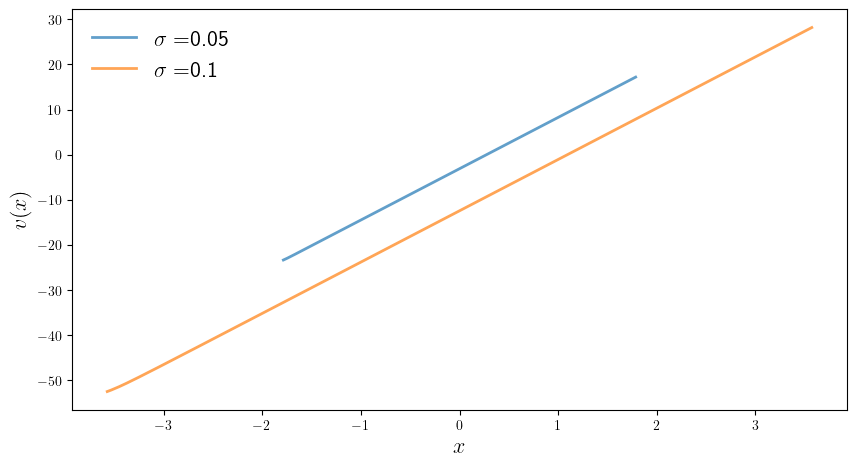

In [4]:
plot_multiple_v(savefig=true)

In [5]:
"""
Epstein--Zin utility: solving the recursion for a given consumption
path.

"""

include("s_approx.jl")
using LinearAlgebra, QuantEcon

function create_ez_utility_model(;
        n=200,      # size of state space
        ρ=0.96,     # correlation coef in AR(1)
        σ=0.1,      # volatility
        β=0.99,     # time discount factor
        α=0.75,     # EIS parameter
        γ=-2.0)     # risk aversion parameter

    mc = tauchen(n, ρ, σ, 0, 5) 
    x_vals, P = mc.state_values, mc.p 
    c = exp.(x_vals)      

    return (; β, ρ, σ, α, γ, c, x_vals, P)
end

function K(v, model)
    (; β, ρ, σ, α, γ, c, x_vals, P) = model

    R = (P * (v.^γ)).^(1/γ)
    return ((1 - β) * c.^α + β * R.^α).^(1/α)
end

function compute_ez_utility(model)
    v_init = ones(length(model.x_vals))
    v_star = successive_approx(v -> K(v, model), 
                               v_init, 
                               tolerance=1e-10)
    return v_star
end


# Plots

using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering
fontsize=16

function plot_convergence(; savefig=false, 
                  num_iter=100,
                  figname="../figures/ez_utility_c.pdf")

    fig, ax = plt.subplots(figsize=(10, 5.2))
    model = create_ez_utility_model()
    (; β, ρ, σ, α, γ, c, x_vals, P) = model


    v_star = compute_ez_utility(model)
    v = 0.1 * v_star
    ax.plot(x_vals, v, lw=3, "k-", alpha=0.7, label=L"v_0")

    greys = [string(g) for g in LinRange(0.0, 0.4, num_iter)]
    greys = reverse(greys)

    for (i, g) in enumerate(greys)
        ax.plot(x_vals, v, "k-", color=g, lw=1, alpha=0.7)
        for t in 1:20
            v = K(v, model)
        end
    end

    v_star = compute_ez_utility(model)
    ax.plot(x_vals, v_star, lw=3, alpha=0.7, label=L"v^*")
    ax.set_xlabel(L"x", fontsize=fontsize)

    ax.legend(frameon=false, fontsize=fontsize, loc="upper left")
    if savefig
        fig.savefig(figname)
    end
end


function plot_v(; savefig=false, 
                  figname="../figures/ez_utility_1.pdf")

    fig, ax = plt.subplots(figsize=(10, 5.2))
    model = create_ez_utility_model()
    (; β, ρ, σ, α, γ, c, x_vals, P) = model
    v_star = compute_ez_utility(model)
    ax.plot(x_vals, v_star, lw=2, alpha=0.7, label=L"v^*")
    ax.set_xlabel(L"x", fontsize=fontsize)

    ax.legend(frameon=false, fontsize=fontsize, loc="upper left")
    if savefig
        fig.savefig(figname)
    end
end


function vary_gamma(; gamma_vals=[1.0, -8.0],
                  savefig=false, 
                  figname="../figures/ez_utility_2.pdf")

    fig, ax = plt.subplots(figsize=(10, 5.2))
    
    for γ in gamma_vals
        model = create_ez_utility_model(γ=γ)
        (; β, ρ, σ, α, γ, c, x_vals, P) = model
        v_star = compute_ez_utility(model)
        ax.plot(x_vals, v_star, lw=2, alpha=0.7, label=L"\gamma="*"$γ")
        ax.set_xlabel(L"x", fontsize=fontsize)
        ax.set_ylabel(L"v(x)", fontsize=fontsize)
    end

    ax.legend(frameon=false, fontsize=fontsize, loc="upper left")
    if savefig
        fig.savefig(figname)
    end
end


function vary_alpha(; alpha_vals=[0.5, 0.6],
                  savefig=false, 
                  figname="../figures/ez_utility_3.pdf")

    fig, ax = plt.subplots(figsize=(10, 5.2))
    
    for α in alpha_vals
        model = create_ez_utility_model(α=α)
        (; β, ρ, σ, α, γ, c, x_vals, P) = model
        v_star = compute_ez_utility(model)
        ax.plot(x_vals, v_star, lw=2, alpha=0.7, label=L"\alpha="*"$α")
        ax.set_xlabel(L"x", fontsize=fontsize)
        ax.set_ylabel(L"v(x)", fontsize=fontsize)
    end

    ax.legend(frameon=false, fontsize=fontsize, loc="upper left")
    if savefig
        fig.savefig(figname)
    end
end


vary_alpha (generic function with 1 method)

Completed iteration 25 with error 0.007206209255429918.
Completed iteration 50 with error 0.00156719788591686.
Completed iteration 75 with error 0.0004273965382449729.
Completed iteration 100 with error 0.00017898582383268913.
Completed iteration 125 with error 9.707282676585383e-5.
Completed iteration 150 with error 6.428406156244737e-5.
Completed iteration 175 with error 5.310395754842823e-5.
Completed iteration 200 with error 4.2962945759894566e-5.
Completed iteration 225 with error 3.408528264214894e-5.
Completed iteration 250 with error 2.686432249121573e-5.
Completed iteration 275 with error 2.1125470141880598e-5.
Completed iteration 300 with error 1.659984383839408e-5.
Completed iteration 325 with error 1.304040010574603e-5.
Completed iteration 350 with error 1.02433780719835e-5.
Completed iteration 375 with error 8.046119378546379e-6.
Completed iteration 400 with error 6.3201732083406625e-6.
Completed iteration 425 with error 4.964472275492682e-6.
Completed iteration 450 with e


Completed iteration 975 with error 2.4504649198675565e-8.
Completed iteration 1000 with error 1.9248809657312904e-8.
Completed iteration 1025 with error 1.5120260599132962e-8.
Completed iteration 1050 with error 1.1877216765654453e-8.
Completed iteration 1075 with error 9.32975185996554e-9.
Completed iteration 1100 with error 7.328675666329332e-9.
Completed iteration 1125 with error 5.756797483158493e-9.
Completed iteration 1150 with error 4.522060725875576e-9.
Completed iteration 1175 with error 3.552153904351485e-9.
Completed iteration 1200 with error 2.790276454334162e-9.
Completed iteration 1225 with error 2.1918089565531318e-9.
Completed iteration 1250 with error 1.7217023362547934e-9.
Completed iteration 1275 with error 1.3524257269637019e-9.
Completed iteration 1300 with error 1.0623533164277887e-9.
Completed iteration 1325 with error 8.344962498796349e-10.
Completed iteration 1350 with error 6.555103126970607e-10.
Completed iteration 1375 with error 5.149147774829999e-10.
Comp


Completed iteration 25 with error 0.007206209255429918.
Completed iteration 50 with error 0.00156719788591686.
Completed iteration 75 with error 0.0004273965382449729.
Completed iteration 100 with error 0.00017898582383268913.
Completed iteration 125 with error 9.707282676585383e-5.
Completed iteration 150 with error 6.428406156244737e-5.
Completed iteration 175 with error 5.310395754842823e-5.
Completed iteration 200 with error 4.2962945759894566e-5.
Completed iteration 225 with error 3.408528264214894e-5.
Completed iteration 250 with error 2.686432249121573e-5.
Completed iteration 275 with error 2.1125470141880598e-5.
Completed iteration 300 with error 1.659984383839408e-5.
Completed iteration 325 with error 1.304040010574603e-5.
Completed iteration 350 with error 1.02433780719835e-5.
Completed iteration 375 with error 8.046119378546379e-6.
Completed iteration 400 with error 6.3201732083406625e-6.
Completed iteration 425 with error 4.964472275492682e-6.
Completed iteration 450 with 

sys:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.


Completed iteration 975 with error 2.4504649198675565e-8.
Completed iteration 1000 with error 1.9248809657312904e-8.
Completed iteration 1025 with error 1.5120260599132962e-8.
Completed iteration 1050 with error 1.1877216765654453e-8.
Completed iteration 1075 with error 9.32975185996554e-9.
Completed iteration 1100 with error 7.328675666329332e-9.
Completed iteration 1125 with error 5.756797483158493e-9.
Completed iteration 1150 with error 4.522060725875576e-9.
Completed iteration 1175 with error 3.552153904351485e-9.
Completed iteration 1200 with error 2.790276454334162e-9.
Completed iteration 1225 with error 2.1918089565531318e-9.
Completed iteration 1250 with error 1.7217023362547934e-9.
Completed iteration 1275 with error 1.3524257269637019e-9.
Completed iteration 1300 with error 1.0623533164277887e-9.
Completed iteration 1325 with error 8.344962498796349e-10.
Completed iteration 1350 with error 6.555103126970607e-10.
Completed iteration 1375 with error 5.149147774829999e-10.
Compl

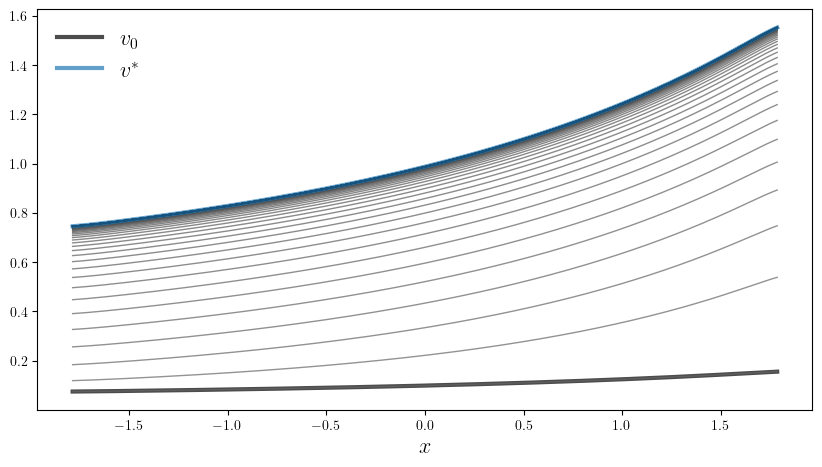

In [6]:
plot_convergence(savefig=true)

Completed iteration 25 with error 0.007206209255429918.
Completed iteration 50 with error 0.00156719788591686.
Completed iteration 75 with error 0.0004273965382449729.
Completed iteration 100 with error 0.00017898582383268913.
Completed iteration 125 with error 9.707282676585383e-5.
Completed iteration 150 with error 6.428406156244737e-5.
Completed iteration 175 with error 5.310395754842823e-5.
Completed iteration 200 with error 4.2962945759894566e-5.
Completed iteration 225 with error 3.408528264214894e-5.
Completed iteration 250 with error 2.686432249121573e-5.
Completed iteration 275 with error 2.1125470141880598e-5.
Completed iteration 300 with error 1.659984383839408e-5.
Completed iteration 325 with error 1.304040010574603e-5.
Completed iteration 350 with error 1.02433780719835e-5.
Completed iteration 375 with error 8.046119378546379e-6.
Completed iteration 400 with error 6.3201732083406625e-6.
Completed iteration 425 with error 4.964472275492682e-6.
Completed iteration 450 with e

Completed iteration 850 with error 8.193544798196228e-8.
Completed iteration 875 with error 6.436164068368555e-8.
Completed iteration 900 with error 5.055713092616543e-8.
Completed iteration 925 with error 3.9713462740564864e-8.
Completed iteration 950 with error 3.119558344977236e-8.
Completed iteration 975 with error 2.4504649198675565e-8.
Completed iteration 1000 with error 1.9248809657312904e-8.
Completed iteration 1025 with error 1.5120260599132962e-8.
Completed iteration 1050 with error 1.1877216765654453e-8.
Completed iteration 1075 with error 9.32975185996554e-9.
Completed iteration 1100 with error 7.328675666329332e-9.
Completed iteration 1125 with error 5.756797483158493e-9.
Completed iteration 1150 with error 4.522060725875576e-9.
Completed iteration 1175 with error 3.552153904351485e-9.
Completed iteration 1200 with error 2.790276454334162e-9.
Completed iteration 1225 with error 2.1918089565531318e-9.
Completed iteration 1250 with error 1.7217023362547934e-9.
Completed iter

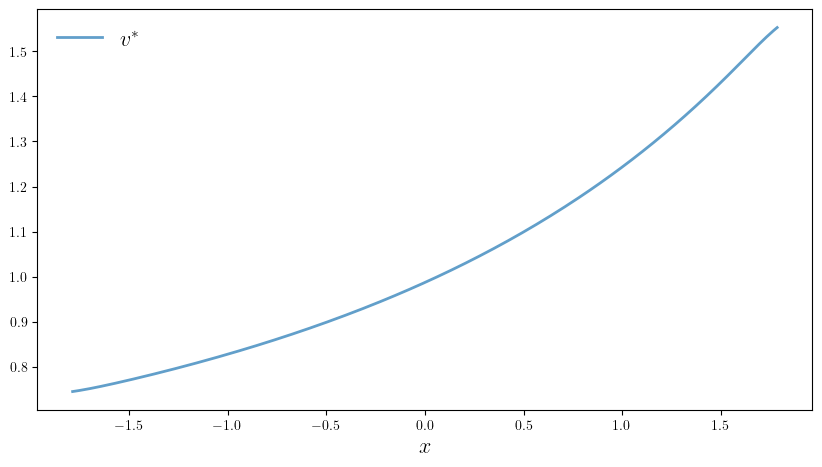

In [7]:
plot_v(savefig=true)

Completed iteration 25 with error 0.0079928250990704.
Completed iteration 50 with error 0.0022236699030695473.
Completed iteration 75 with error 0.0007925233675871723.
Completed iteration 100 with error 0.0003700089153120256.
Completed iteration 125 with error 0.00022014006478499049.
Completed iteration 150 with error 0.000152329026353204.
Completed iteration 175 with error 0.00011314688364416625.
Completed iteration 200 with error 8.647303897579839e-5.
Completed iteration 225 with error 6.67984175424241e-5.
Completed iteration 250 with error 5.18016731108073e-5.
Completed iteration 275 with error 4.0227726982866585e-5.
Completed iteration 300 with error 3.1254842565831e-5.
Completed iteration 325 with error 2.4287249895227347e-5.
Completed iteration 350 with error 1.8873788653950285e-5.
Completed iteration 375 with error 1.4667052229189181e-5.
Completed iteration 400 with error 1.1397890212316852e-5.
Completed iteration 425 with error 8.857330340950043e-6.
Completed iteration 450 with


Completed iteration 925 with error 5.709751449423095e-8.
Completed iteration 950 with error 4.436905820526249e-8.
Completed iteration 975 with error 3.447808993861656e-8.
Completed iteration 1000 with error 2.6792065010994293e-8.
Completed iteration 1025 with error 2.0819445056829977e-8.
Completed iteration 1050 with error 1.6178271167177627e-8.
Completed iteration 1075 with error 1.257173076751883e-8.
Completed iteration 1100 with error 9.769177466978363e-9.
Completed iteration 1125 with error 7.591384187932704e-9.
Completed iteration 1150 with error 5.899075006254861e-9.
Completed iteration 1175 with error 4.584023605147536e-9.
Completed iteration 1200 with error 3.5621303684507666e-9.
Completed iteration 1225 with error 2.7680424619092037e-9.
Completed iteration 1250 with error 2.150976285975048e-9.
Completed iteration 1275 with error 1.6714698514164184e-9.
Completed iteration 1300 with error 1.2988572439809332e-9.
Completed iteration 1325 with error 1.0093095248464579e-9.
Complete

Completed iteration 100 with error 0.0006103613807980635.
Completed iteration 125 with error 0.0005311884300758241.
Completed iteration 150 with error 0.00043698527493063466.
Completed iteration 175 with error 0.00035198104401934494.
Completed iteration 200 with error 0.00028172941742132807.
Completed iteration 225 with error 0.00022510364302386066.
Completed iteration 250 with error 0.00017979635634590707.
Completed iteration 275 with error 0.0001436170545812132.
Completed iteration 300 with error 0.0001147362910276506.
Completed iteration 325 with error 9.167841288770795e-5.
Completed iteration 350 with error 7.326486227898776e-5.
Completed iteration 375 with error 5.855662116727167e-5.
Completed iteration 400 with error 4.680563708592267e-5.
Completed iteration 425 with error 3.741571258686349e-5.
Completed iteration 450 with error 2.9911412434691087e-5.
Completed iteration 475 with error 2.3913408442099993e-5.
Completed iteration 500 with error 1.9118921097849295e-5.
Completed iter


Completed iteration 1000 with error 2.1828008911484176e-7.
Completed iteration 1025 with error 1.7454391376681144e-7.
Completed iteration 1050 with error 1.3957107514173117e-7.
Completed iteration 1075 with error 1.1160566559809126e-7.
Completed iteration 1100 with error 8.924361205586706e-8.
Completed iteration 1125 with error 7.136217905490128e-8.
Completed iteration 1150 with error 5.706359362811497e-8.
Completed iteration 1175 with error 4.5629968914440155e-8.
Completed iteration 1200 with error 3.6487260768325314e-8.
Completed iteration 1225 with error 2.9176445481837732e-8.
Completed iteration 1250 with error 2.3330471332627667e-8.
Completed iteration 1275 with error 1.8655833988745485e-8.
Completed iteration 1300 with error 1.4917836299588316e-8.
Completed iteration 1325 with error 1.1928807275296549e-8.
Completed iteration 1350 with error 9.538678735765416e-9.
Completed iteration 1375 with error 7.627450671066072e-9.
Completed iteration 1400 with error 6.099168059492399e-9.
Co


Completed iteration 1825 with error 1.3627632355905916e-10.
Completed iteration 1850 with error 1.0897172053603299e-10.
Terminated successfully in 1861 iterations.

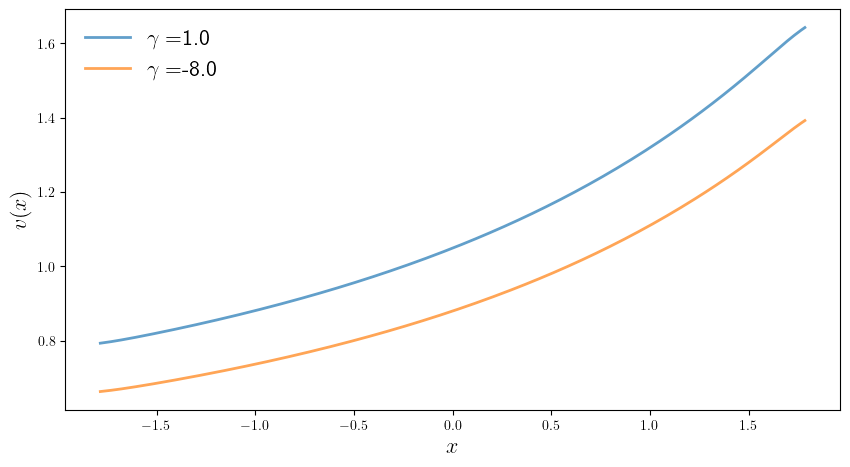

In [8]:
vary_gamma(savefig=true)

Completed iteration 25 with error 0.00705978038298638.
Completed iteration 50 with error 0.0016244720239249055.
Completed iteration 75 with error 0.0004469052464325385.
Completed iteration 100 with error 0.00019885551337017748.
Completed iteration 125 with error 0.0001136541590511797.
Completed iteration 150 with error 9.197108433633971e-5.
Completed iteration 175 with error 7.72108640880731e-5.
Completed iteration 200 with error 6.18447413132106e-5.
Completed iteration 225 with error 4.877743776865451e-5.
Completed iteration 250 with error 3.826910525028815e-5.
Completed iteration 275 with error 2.997076483612915e-5.
Completed iteration 300 with error 2.3457884571698173e-5.
Completed iteration 325 with error 1.835697143692805e-5.
Completed iteration 350 with error 1.4364647692000077e-5.
Completed iteration 375 with error 1.1240612030949393e-5.
Completed iteration 400 with error 8.796119907339417e-6.
Completed iteration 425 with error 6.8833377468990875e-6.
Completed iteration 450 with


Completed iteration 975 with error 3.1297297642396416e-8.
Completed iteration 1000 with error 2.449310043672881e-8.
Completed iteration 1025 with error 1.9168171716543725e-8.
Completed iteration 1050 with error 1.5000912290119572e-8.
Completed iteration 1075 with error 1.1739636152086064e-8.
Completed iteration 1100 with error 9.187378857689055e-9.
Completed iteration 1125 with error 7.1899948217435394e-9.
Completed iteration 1150 with error 5.626853871731896e-9.
Completed iteration 1175 with error 4.40354752662131e-9.
Completed iteration 1200 with error 3.4461931086582354e-9.
Completed iteration 1225 with error 2.6969735333892686e-9.
Completed iteration 1250 with error 2.1106374425983176e-9.
Completed iteration 1275 with error 1.651774939048778e-9.
Completed iteration 1300 with error 1.292670193109302e-9.
Completed iteration 1325 with error 1.0116376625290968e-9.
Completed iteration 1350 with error 7.917018152170385e-10.
Completed iteration 1375 with error 6.195819413079562e-10.
Comp


Completed iteration 300 with error 2.0659148304957853e-5.
Completed iteration 325 with error 1.6191113263452905e-5.
Completed iteration 350 with error 1.2688664559057372e-5.
Completed iteration 375 with error 9.943784911037312e-6.
Completed iteration 400 with error 7.792746775203696e-6.
Completed iteration 425 with error 6.107082487050164e-6.
Completed iteration 450 with error 4.786093088071652e-6.
Completed iteration 475 with error 3.7508697376953393e-6.
Completed iteration 500 with error 2.9395824157063544e-6.
Completed iteration 525 with error 2.303782836721169e-6.
Completed iteration 550 with error 1.8055071033806769e-6.
Completed iteration 575 with error 1.415005903782074e-6.
Completed iteration 600 with error 1.1089664067043259e-6.
Completed iteration 625 with error 8.691192774357148e-7.
Completed iteration 650 with error 6.811473081125285e-7.
Completed iteration 675 with error 5.338303132873534e-7.
Completed iteration 700 with error 4.1837509945352735e-7.
Completed iteration 72

Completed iteration 1100 with error 8.47590220232064e-9.
Completed iteration 1125 with error 6.6427816580727495e-9.
Completed iteration 1150 with error 5.2061188693386384e-9.
Completed iteration 1175 with error 4.080168647391247e-9.
Completed iteration 1200 with error 3.1977336334421125e-9.
Completed iteration 1225 with error 2.5061457353814376e-9.
Completed iteration 1250 with error 1.9641301918227327e-9.
Completed iteration 1275 with error 1.5393402108543341e-9.
Completed iteration 1300 with error 1.2064202969952476e-9.
Completed iteration 1325 with error 9.45502121041386e-10.
Completed iteration 1350 with error 7.410141389385672e-10.
Completed iteration 1375 with error 5.807518910216913e-10.
Completed iteration 1400 with error 4.551501397997981e-10.
Completed iteration 1425 with error 3.567128814552234e-10.
Completed iteration 1450 with error 2.7956503778625574e-10.
Completed iteration 1475 with error 2.191020698205648e-10.
Completed iteration 1500 with error 1.717159747727237e-10.


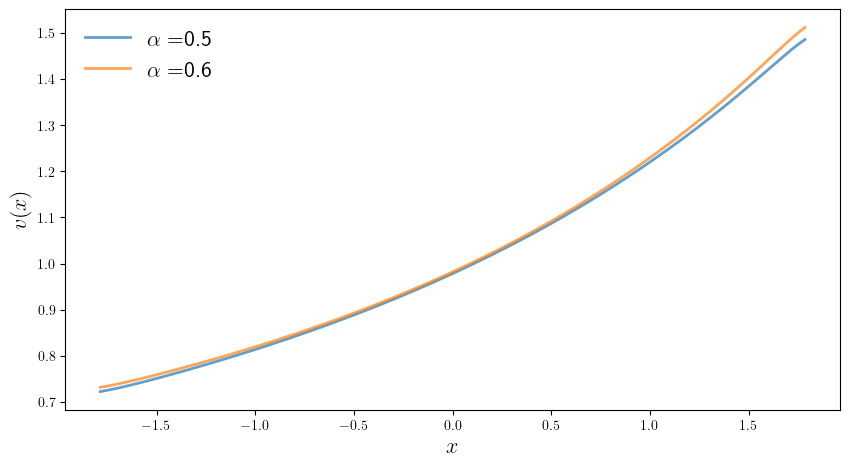

In [9]:
vary_alpha(savefig=true)